# Simple tutorial for computational model for a single abstract network using a firing-rate network model
### Demo code for Ito et al., 2017 

#### Author: Takuya Ito (takuya.ito@rutgers.edu)

#### Ito T, Kulkarni KR, Schultz DH, Mill RD, Chen RH, Solomyak LI, Cole MW (2017). Cognitive task information is transferred between brain regions via resting-state network topology. bioRxiv. https://doi.org/10.1101/101782

**Summary:** Generates a network with five subnetworks, comprising of a single hub network and four local networks. We employ a firing rate code model, and simulate functional MRI data by convolving the simulated signal with a hemodynamic response function (defined in model.py module).

We demonstrate simple simulations and analyses, generating resting-state activity and resting-state FC matrices using both Pearson correlation and multiple linear regression.



#### Import required packages

In [1]:
import sys
sys.path.append('utils/')
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm

## Import custom modules
# Primary module with most model functions
import model
# Module for FC regression
import multregressionconnectivity as mreg

# Firing rate model formulation

#### See Methods section for full description. 

#### Mathematical formulation adapted from Stern et al., 2014.


$$ \frac{dx_{i}}{dt} \tau_{i} = -x_{i}(t) + s \hspace{3 pt} \phi \hspace{1 pt} \bigg{(} x_i(t) \bigg{)} + g \bigg{(} \sum_{j\neq i}^{N} W_{ij} \hspace{3 pt} \phi \hspace{1 pt} \bigg{(} x_{j}(t) \bigg{)} \bigg{)} + I_{i}(t)$$

where $x_i$ is the activity of region $i$, $\tau_{i}$ is the time constant for region $i$, $s$ is the recurrent (local) coupling parameter, $g$ is the global coupling parameter, $\phi$ is the hyperbolic tangent (i.e., bounded transfer function), $W$ is the synaptic connectivity matrix, and $I$ is the task-stimulation (if any). For resting-state simulations, $I_{i}(t) = 0$ for all $\forall t$ and $\forall i \in [1,..,250]$.

In [2]:
# Define transfer function
phi = lambda x: np.tanh(x)

## 1.0 Define simulation parameters and configure network matrices

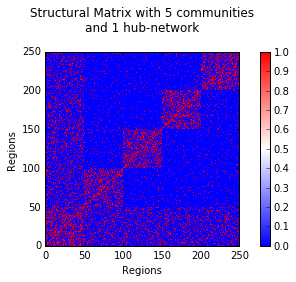

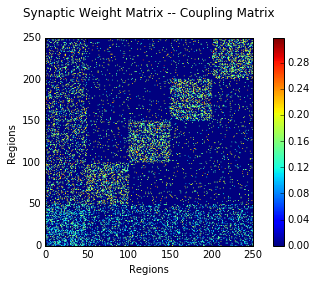

In [28]:
## Set up simulation parameters
nblocks = 20
ntasks = 4
Tmax = 10000
Tmaxrest = 60000
dt = 1.0
tau = 1.0
g = 1.0
s = 1.0
TRLength = 100

#### Set up subject network matrix ####
# Parameters for subject's networks
ncommunities = 5
innetwork_dsity = .35
outnetwork_dsity = .05
hubnetwork_dsity = .20

nodespercommunity = 50
totalnodes = nodespercommunity*ncommunities

# Construct structural matrix
W = model.generateStructuralNetwork(ncommunities=ncommunities,
                                    innetwork_dsity=innetwork_dsity,
                                    outnetwork_dsity=outnetwork_dsity,
                                    hubnetwork_dsity=hubnetwork_dsity,
                                    nodespercommunity=nodespercommunity,
                                    showplot=True)
# Construct synaptic matrix
G = model.generateSynapticNetwork(W, showplot=True)


## 1.1 Run a resting-state simulation and plot (i.e., no task stimulation)

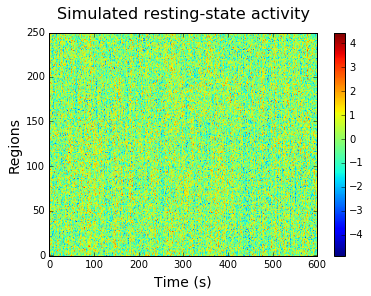

In [29]:
restdata = model.networkModel(G, 
                              Tmax=Tmaxrest,
                              dt=dt,
                              g=g,
                              s=s,
                              tau=tau,
                              I=None,
                              noise=1)

plt.figure()
plt.imshow(restdata, aspect='auto',origin='lower')
plt.title('Simulated resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.xticks(np.arange(0,Tmaxrest+1,10000),np.arange(0,Tmaxrest+1,10000)/100)
plt.colorbar()

## 1.2 Convolve simulation with hemodynamic response function to generate fMRI data
* Simulated fMRI data sampled at 1 second TRs (simulated data sampled at 10ms)

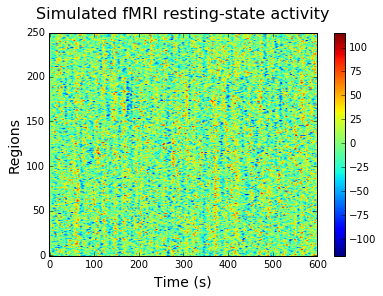

In [30]:
restfmri = model.convolveTimeseries(restdata,
                                    samplingrate=dt,
                                    TRLength=TRLength)
plt.figure()
plt.imshow(restfmri, aspect='auto',origin='lower')
plt.title('Simulated fMRI resting-state activity', y=1.04, fontsize=16)
plt.ylabel('Regions',fontsize=14)
plt.xlabel('Time (s)',fontsize=14)
plt.colorbar()

## 1.3 Recover resting-state functional connectivity matrix using Pearson correlation

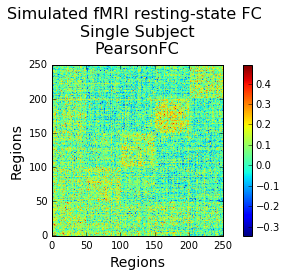

In [48]:
fcmat = np.corrcoef(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat,0)

plt.figure()
plt.imshow(fcmat, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC \nSingle Subject\nPearsonFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()

## 1.4 Recover resting-state functional connectivity matrix using Multiple Linear Regression

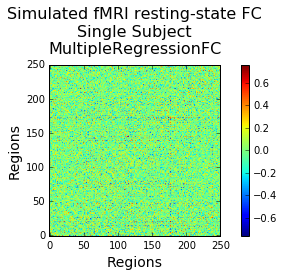

In [50]:
fcmat_mreg = mreg.multregressionconnectivity(restfmri)
# 0 out the diagonal
np.fill_diagonal(fcmat_mreg,0)

plt.figure()
plt.imshow(fcmat_mreg, origin='lower')
plt.colorbar()
plt.title('Simulated fMRI resting-state FC\nSingle Subject\nMultipleRegressionFC', y=1.04, fontsize=16)
plt.xlabel('Regions',fontsize=14)
plt.ylabel('Regions', fontsize=14)
plt.tight_layout()